In [1]:
from bs4 import BeautifulSoup
import requests
import nltk
import math
nltk.download('stopwords')
import pandas as pd
import pickle
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import networkx.algorithms.community as nx_community
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
import networkx.algorithms.community as nx_comm
import netwulf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import Counter
from collections import defaultdict

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


## Collecting data with Harry Potter API

In [75]:
# API link
BASE_URL = "https://api.potterdb.com/"
VERSION = "v1/"
RESOURCE = "characters"

my_url = BASE_URL + VERSION + RESOURCE
print(my_url)
all_data = {}
counter = 0
for i in range(50):

    url = my_url + f"?page[number={i+1}]&page[size=100]"
    r = requests.get(url)
    data = r.json()["data"]

    for i in data:
        all_data[counter] = {}
        name = (i['attributes']['name'])
        all_data[counter]['Name'] = i['attributes']['name']
        all_data[counter]['Blood status'] = i['attributes']['blood_status']
        all_data[counter]['House'] = i['attributes']['house']
        all_data[counter]['Species'] = i['attributes']['species']
        all_data[counter]['Death time'] = i['attributes']['died']
        all_data[counter]['Alias'] = i['attributes']['alias_names']
        all_data[counter]['Wiki'] = i['attributes']['wiki']
        all_data[counter]['Gender'] = i['attributes']['gender']
        counter +=1
    
df_data = pd.DataFrame.from_dict(all_data, orient='index')

https://api.potterdb.com/v1/characters


In [210]:
df_data.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
0,1992 Gryffindor vs Slytherin Quidditch match s...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1992_Gryff...,None,The title of this article is conjectural. Alt...,"[Canon, Filius_Flitwick, Irma_Pince, Severus_S...",1992_Gryffindor_vs_Slytherin_Quidditch_match_s...,"{'Filius_Flitwick': 2, 'Irma_Pince': 3, 'Sever..."
1,1996 Gryffindor Quidditch Keeper trials specta...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1996_Gryff...,None,"In September 1996, a number of unidentified sp...","[Harry_Potter_and_the_Half-Blood_Prince, Septe...",1996_Gryffindor_Quidditch_Keeper_trials_specta...,"{'Harry_Potter': 1, 'Ronald_Weasley': 1, 'Corm..."


## Webscrape text data and node links from wiki

In [114]:
# Function to webscrape Harry Potter wiki for text and links
def webscrapeWiki(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    content_div = soup.find('div', {'id': 'mw-content-text'})
    text = ""
    for p in content_div.find_all('p'):
        text += p.get_text() + " "

    links = []
    for a in content_div.find_all("a"):
        split = a['href'].split("/")
        if len(split)>1:
            if split[1]=="wiki":
                links.append(split[2])

    return text, links

df_data["Wiki text"], df_data["Character links"] = zip(*df_data["Wiki"].apply(webscrapeWiki))

In [209]:
df_data.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
0,1992 Gryffindor vs Slytherin Quidditch match s...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1992_Gryff...,None,The title of this article is conjectural. Alt...,"[Canon, Filius_Flitwick, Irma_Pince, Severus_S...",1992_Gryffindor_vs_Slytherin_Quidditch_match_s...,"{'Filius_Flitwick': 2, 'Irma_Pince': 3, 'Sever..."
1,1996 Gryffindor Quidditch Keeper trials specta...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1996_Gryff...,None,"In September 1996, a number of unidentified sp...","[Harry_Potter_and_the_Half-Blood_Prince, Septe...",1996_Gryffindor_Quidditch_Keeper_trials_specta...,"{'Harry_Potter': 1, 'Ronald_Weasley': 1, 'Corm..."


In [120]:
def wikiName(wikiURL):
    return wikiURL.split("/")[-1]

def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks

df_data["Wiki name"] = df_data["Wiki"].apply(wikiName)
df_data["Sum character links"] = df_data["Character links"].apply(Counter)
df_data["Sum character links"] = df_data["Sum character links"].apply(checkLinks,wikiNames=df_data["Wiki name"])

#Save dataframe
df_data.to_pickle("df_data")

## Initial filtering of data

In [12]:
# Load dataframe:
df_data_loaded = pd.read_pickle("df_data")

In [13]:
# Getting filtered data
def checkUnidentified(wikiName):
    check = "Unidentified"
    if len(wikiName)>len(check):
        if wikiName[:len(check)]==check:
            return True
    return False

def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks

filtered_data = df_data_loaded[~((df_data_loaded["Blood status"].isnull())&(df_data_loaded["House"].isnull())&(df_data_loaded["Species"].isnull())&(df_data_loaded["Death time"].isnull())&(df_data_loaded["Alias"].isnull()))]
filtered_data = filtered_data[~filtered_data["Wiki name"].apply(checkUnidentified)]
filtered_data["Sum character links"] = filtered_data["Sum character links"].apply(checkLinks,wikiNames=filtered_data["Wiki name"])

In [62]:
def cleanHouses(House):
    if House != None:
        strings = House.split(' ')
        if len(strings) == 1:
            return strings[0]
        if len(strings) != 1:
            if len(strings) > 2:
                return 'Unknown'
            if strings[-1][-1] == ')':
                return strings[0]
    if House == None:
        return 'Unknown'

filtered_data['House'] = filtered_data['House'].apply(cleanHouses)

In [135]:
def cleanSpecies(Species):
    if Species != None:
        strings = Species.split(' ')
        if len(strings) == 1:
            return strings[0]
        if strings[-1][-1] == 's':
            l = len(string[-1])
            return strings[-1][0:(l-1)]
        if len(strings) > 2:
            return strings[0]
    if Species == None:
        return 'Unknown'

copy = filtered_data.copy()
copy['Species'] = filtered_data['Species'].apply(cleanSpecies)

Code below makes complete list of HP actors, that we can use to filter the df (Jeg gør den lidt mere efficient om lidt)

In [27]:
# Full cast and crew for The Philosopher's Stone at IMDb

url = 'https://www.imdb.com/title/tt0241527/fullcredits#cast'
response = requests.get(url)

if response.status_code == 200:
    html_content = response.content
    soup = BeautifulSoup(html_content, 'html.parser')
    # Find the cast elements
    cast_element = soup.find('table', class_='cast_list')

    # Extract the actor names from the cast element
    actor_names = []
    if cast_element:
        for row in cast_element.find_all('tr'):
            actor_element = row.find('td', class_='primary_photo')
            if actor_element:
                actor_name = actor_element.find('img').get('alt')
                actor_names.append(actor_name)

# Full cast and crew for The Chamber of Secrets at IMDb

new_url = 'https://www.imdb.com/title/tt0295297/fullcredits#cast'
response2 = requests.get(new_url)

if response2.status_code == 200:
    new_html_content = response2.content
    new_soup = BeautifulSoup(new_html_content, 'html.parser')
    new_cast_element = new_soup.find('table', class_='cast_list')

    new_actor_names = []
    if new_cast_element:
        for row in new_cast_element.find_all('tr'):
            actor_element = row.find('td', class_='primary_photo')
            if actor_element:
                actor_name = actor_element.find('img').get('alt')
                new_actor_names.append(actor_name)

    # Add only new actors to list 'actor_names'
    for actor_name in new_actor_names:
        if actor_name not in actor_names:
            actor_names.append(actor_name)

# Full cast and crew for The Prisoner of Azkaban at IMDb

new_url = 'https://www.imdb.com/title/tt0304141/fullcredits#cast'
response3 = requests.get(new_url)

if response3.status_code == 200:
    new_html_content = response3.content
    new_soup = BeautifulSoup(new_html_content, 'html.parser')
    new_cast_element = new_soup.find('table', class_='cast_list')

    new_actor_names = []
    if new_cast_element:
        for row in new_cast_element.find_all('tr'):
            actor_element = row.find('td', class_='primary_photo')
            if actor_element:
                actor_name = actor_element.find('img').get('alt')
                new_actor_names.append(actor_name)

    # Add only new actors to list 'actor_names'
    for actor_name in new_actor_names:
        if actor_name not in actor_names:
            actor_names.append(actor_name)

# Full cast and crew for The Goblet of Fire at IMDb

new_url = 'https://www.imdb.com/title/tt0330373/fullcredits#cast'
response4 = requests.get(new_url)

if response4.status_code == 200:
    new_html_content = response4.content
    new_soup = BeautifulSoup(new_html_content, 'html.parser')
    new_cast_element = new_soup.find('table', class_='cast_list')

    new_actor_names = []
    if new_cast_element:
        for row in new_cast_element.find_all('tr'):
            actor_element = row.find('td', class_='primary_photo')
            if actor_element:
                actor_name = actor_element.find('img').get('alt')
                new_actor_names.append(actor_name)

    # Add only new actors to list 'actor_names'
    for actor_name in new_actor_names:
        if actor_name not in actor_names:
            actor_names.append(actor_name)

# Full cast and crew for The Order of the Phoenix at IMDb

new_url = 'https://www.imdb.com/title/tt0373889/fullcredits#cast'
response5 = requests.get(new_url)

if response5.status_code == 200:
    new_html_content = response5.content
    new_soup = BeautifulSoup(new_html_content, 'html.parser')
    new_cast_element = new_soup.find('table', class_='cast_list')

    new_actor_names = []
    if new_cast_element:
        for row in new_cast_element.find_all('tr'):
            actor_element = row.find('td', class_='primary_photo')
            if actor_element:
                actor_name = actor_element.find('img').get('alt')
                new_actor_names.append(actor_name)

    # Add only new actors to list 'actor_names'
    for actor_name in new_actor_names:
        if actor_name not in actor_names:
            actor_names.append(actor_name)


# Full cast and crew for The Half-Blood Prince at IMDb

new_url = 'https://www.imdb.com/title/tt0417741/fullcredits#cast'
response6 = requests.get(new_url)

if response6.status_code == 200:
    new_html_content = response6.content
    new_soup = BeautifulSoup(new_html_content, 'html.parser')
    new_cast_element = new_soup.find('table', class_='cast_list')

    new_actor_names = []
    if new_cast_element:
        for row in new_cast_element.find_all('tr'):
            actor_element = row.find('td', class_='primary_photo')
            if actor_element:
                actor_name = actor_element.find('img').get('alt')
                new_actor_names.append(actor_name)

    # Add only new actors to list 'actor_names'
    for actor_name in new_actor_names:
        if actor_name not in actor_names:
            actor_names.append(actor_name)


# Full cast and crew for The Deathly Hallows – Part 1 at IMDb

new_url = 'https://www.imdb.com/title/tt0926084/fullcredits#cast'
response7 = requests.get(new_url)

if response7.status_code == 200:
    new_html_content = response7.content
    new_soup = BeautifulSoup(new_html_content, 'html.parser')
    new_cast_element = new_soup.find('table', class_='cast_list')

    new_actor_names = []
    if new_cast_element:
        for row in new_cast_element.find_all('tr'):
            actor_element = row.find('td', class_='primary_photo')
            if actor_element:
                actor_name = actor_element.find('img').get('alt')
                new_actor_names.append(actor_name)

    # Add only new actors to list 'actor_names'
    for actor_name in new_actor_names:
        if actor_name not in actor_names:
            actor_names.append(actor_name)


# Full cast and crew for The Deathly Hallows – Part 2 at IMDb

new_url = 'https://www.imdb.com/title/tt1201607/fullcredits#cast'
response8 = requests.get(new_url)

if response8.status_code == 200:
    new_html_content = response8.content
    new_soup = BeautifulSoup(new_html_content, 'html.parser')
    new_cast_element = new_soup.find('table', class_='cast_list')

    new_actor_names = []
    if new_cast_element:
        for row in new_cast_element.find_all('tr'):
            actor_element = row.find('td', class_='primary_photo')
            if actor_element:
                actor_name = actor_element.find('img').get('alt')
                new_actor_names.append(actor_name)

    # Add only new actors to list 'actor_names'
    for actor_name in new_actor_names:
        if actor_name not in actor_names:
            actor_names.append(actor_name)

# actor_names


In [7]:
filtered_data.head(5)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
5,2-Headed Baby,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/2-Headed_Baby,Male (most likely),\n\n\n\n\n\n\n\n2-Headed Baby\n\n\nBiographica...,"[1927, Human, Circus_Arcanus, Template:Individ...",2-Headed_Baby,{}
7,Aamir Loonat,None,Gryffindor,Human,None,None,https://harrypotter.fandom.com/wiki/Aamir_Loonat,Male,\n\nAamir Loonat\n\n\nBiographical information...,"[31_August, 1982, Great_Britain, Ireland, Huma...",Aamir_Loonat,{}
8,Abel Treetops,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Abel_Treetops,Male,\n\nAbel Treetops\n\n\nBiographical informatio...,"[1832, United_States_of_America, Human, Templa...",Abel_Treetops,{}
9,Aberforth Dumbledore,Half-blood,None,Human,None,[Ab],https://harrypotter.fandom.com/wiki/Aberforth_...,Male,At least some content in this article is deriv...,"[Harry_Potter:_Hogwarts_Mystery, Harry_Potter:...",Aberforth_Dumbledore,"{'Percival_Dumbledore': 4, 'Kendra_Dumbledore'..."
10,Abernathy,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Abernathy,Male,At least some content in this article is deriv...,"[Fantastic_Beasts:_The_Secrets_of_Dumbledore, ...",Abernathy,"{'Gellert_Grindelwald': 6, 'Porpentina_Goldste..."


## Make network

In [69]:
# making edgelist
wiki_names = list(filtered_data['Wiki name'])
character_links = filtered_data['Sum character links']
houses = list(filtered_data['House'])

# Initializing graph
G = nx.MultiDiGraph()
# Adding group according to house attribute
for i in range(len(wiki_names)):
        G.add_node(wiki_names[i], group = houses[i])
print(G)

MultiDiGraph with 3542 nodes and 0 edges


In [70]:
# Making weighted edgelist
edges = []
for j in filtered_data.index:
    name = filtered_data['Wiki name'][j]
    links = filtered_data['Sum character links'][j]
    for key, val in links.items():
        edges.append(((name, key, val)))

In [71]:
# Adding edgelist to graph
G.add_weighted_edges_from(edges)
print(G)

MultiDiGraph with 3542 nodes and 110998 edges


In [73]:
# Remove nodes with no edges
remove = [node for node,degree in G.degree() if degree == 0]
G.remove_nodes_from(remove)
print(f"{len(remove)} nodes with degree 0 were removed.")
print(G)

551 nodes with degree 0 were removed.
MultiDiGraph with 2991 nodes and 110998 edges


In [29]:
# Interactive visualization of graph (with group attribute according to 'house')
netwulf.interactive.visualize(G)

(None, None)

### Investigating communities

In [74]:
# Finding communities from splitting graph by 'House' attribute
import networkx.algorithms.community as nx_comm
houses_types = []
for i in houses:
    if i not in houses_types:
        houses_types.append(i)
    
print('The different houses are:', houses_types)

houses_com = []
for i in houses_types:
    houses_com.append({x for x,y in G.nodes(data=True) if y['group']==i})

# computing modularity of 'house' split
house_mod = nx_comm.modularity(G, houses_com)
print('The modularity for the "house" split is: ' + str(house_mod))
no_comm = len(houses_com)
print('The number of "house" communities is ' + str(no_comm))
size_comm = []
for i in range(no_comm):
    size_comm.append(len(houses_com[i]))

The different houses are: ['Unknown', 'Gryffindor', 'Slytherin', 'Hufflepuff', 'Ravenclaw', 'Thunderbird', 'Pukwudgie', 'Wampus']
The modularity for the "house" split is: 0.16492535393916527
The number of "house" communities is 8


Text(0, 0.5, 'Count')

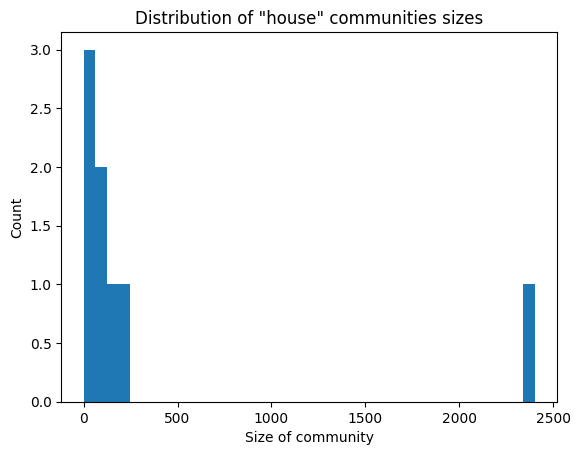

In [75]:
# Plotting distribution of sizes of 'house' communities
bins = np.linspace(min(size_comm), max(size_comm), 40)
hist, edges = np.histogram(size_comm, bins=bins)
x = (edges[1:]+edges[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_title('Distribution of "house" communities sizes')
ax.set_xlabel('Size of community')
ax.set_ylabel('Count')

In [76]:
# Finding louvain communities
louv_comm = nx_comm.louvain_communities(G)

modularity_louv = nx_comm.modularity(G, louv_comm)
print('The modularity of Louvain algorithm is ' + str(modularity_louv))

no_comm = len(louv_comm)
print('The number of Louvain communities is ' + str(no_comm))

size_comm = []
for i in range(no_comm):
    size_comm.append(len(louv_comm[i]))

The modularity of Louvain algorithm is 0.6087253583484655
The number of Louvain communities is 223


Text(0, 0.5, 'Count')

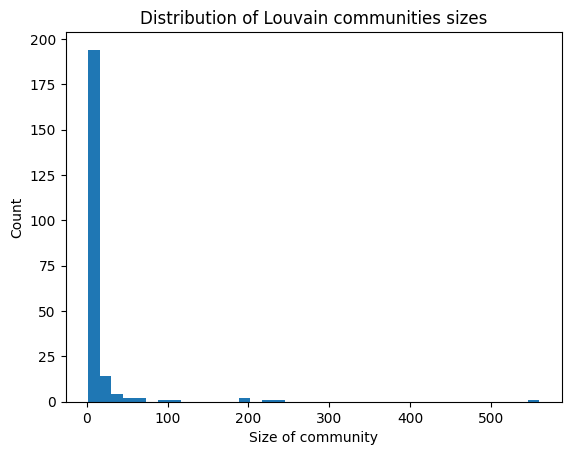

In [77]:
# Plotting distribution of comminuty sizes
bins = np.linspace(min(size_comm), max(size_comm), 40)
hist, edges = np.histogram(size_comm, bins=bins)
x = (edges[1:]+edges[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_title('Distribution of Louvain communities sizes')
ax.set_xlabel('Size of community')
ax.set_ylabel('Count')
#ax.set_ylim(0,20)

## Visualizations

In [215]:
# First filter dataset by removing nodes with degree 0:
filtered_data2 = filtered_data[~filtered_data['Wiki name'].isin(remove)]
filtered_data2.head(2)

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
9,Aberforth Dumbledore,Half-blood,None,Human,None,[Ab],https://harrypotter.fandom.com/wiki/Aberforth_...,Male,At least some content in this article is deriv...,"[Harry_Potter:_Hogwarts_Mystery, Harry_Potter:...",Aberforth_Dumbledore,"{'Percival_Dumbledore': 4, 'Kendra_Dumbledore'..."
10,Abernathy,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Abernathy,Male,At least some content in this article is deriv...,"[Fantastic_Beasts:_The_Secrets_of_Dumbledore, ...",Abernathy,"{'Gellert_Grindelwald': 6, 'Porpentina_Goldste..."


In [244]:
# Plotting distribution of species
species = filtered_data2['Species']
species_freq = defaultdict(int)
for item in species:
    species_freq[item] += 1

species_freq["Unknown"] = species_freq[None]
del species_freq[None]


In [222]:
# Plotting distribution of species
species = filtered_data2['Species']
species_freq = defaultdict()
for item in species:
    species_freq += 1

    
# Finding all types of species
species_types = []
for i in species:
    if i not in species_types:
        species_types.append(i)

print(len(species_types))

# Converting each species to an integer
dict = {}
for i in range(len(species_types)):
    dict[i] = species_types[i]
keys = list(dict.keys())
values = list(dict.values())

# Making list of species integers
species_int = []
for i in species:
    for j in range(len(values)):
        if i == values[j]:
            species_int.append(keys[j])


174
hello


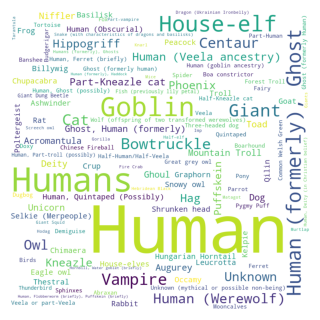

In [251]:
# Define a function to generate wordcloud
def generate_freq_wordcloud(data):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10)
    wordcloud.generate_from_frequencies(frequencies = data)
    plt.figure(figsize = (3,3), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

generate_freq_wordcloud(species_freq)

Text(0, 0.5, 'Count')

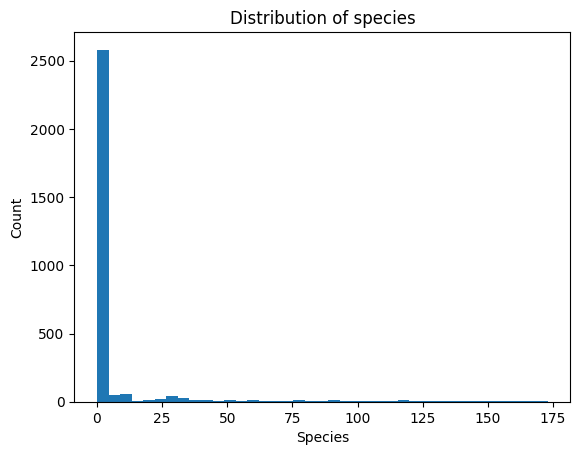

In [217]:
# Plotting distribution
bins = np.linspace(min(species_int), max(species_int), 40)
hist, edges = np.histogram(species_int, bins=bins)
x = (edges[1:]+edges[:-1])/2
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_title('Distribution of species')
ax.set_xlabel('Species')
ax.set_ylabel('Count')
# Very heavy tailed therefore log transforming

Text(0.5, 1.0, 'Distribution of species in log space')

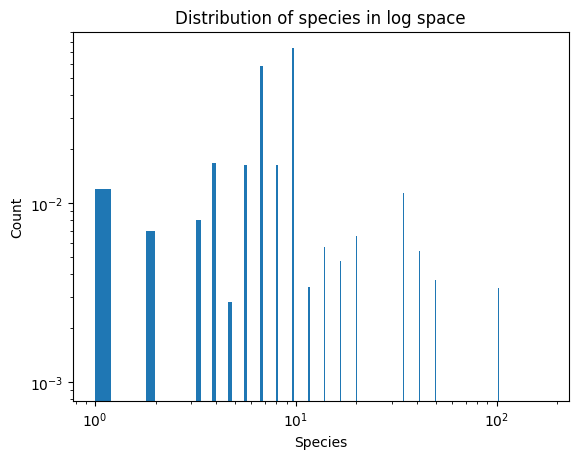

In [218]:
# Plotting species distribution in log space
bins = np.logspace(0, np.log10(192), 30)
hist, edges = np.histogram(species_int, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Species')
ax.set_ylabel('Count')
ax.set_title('Distribution of species in log space')

# Semantic analysis of communities/houses

Pusher senere